# Case study of uniaxial tensile tests

This is an example of how to use ParaMaterial to process a dataset of uniaxial tensile test measurements.



## Data processing
- **Trim data**
- **Identify linear region**
- **Shift curves (foot correction)**

Import libraries and objects.

In [1]:
from typing import Callable

import numpy as np
import pandas as pd

import paramaterial as pam
from paramaterial.plug import DataSet, DataItem

Setup plotting function.
We will be colouring by temperature during processing, as it is easier to observe the dataset than when colouring by lot.
We also now introduce the dataset_subplots function and the subplot_wrapper function, which we use to split the dataset_plot over subplots grouped by lot.

In [2]:
prepared_ds = DataSet('data/01 prepared data', 'info/01 prepared info.xlsx').sort_by(['temperature', 'lot'])
styler = pam.plotting.Styler(color_by='temperature', cmap='plasma', color_by_label='(°C)',
                             plot_kwargs=dict(grid=True)).style_to(prepared_ds)
subplot_cfg = dict(shape=(3, 3), figsize=(8, 6), hspace=0.2,
                   sharex='all', sharey='all',
                   rows_by='lot', row_vals=[[a] for a in 'ABCDEFGHI'],
                   cols_by='lot', col_vals=[[a] for a in 'ABCDEFGHI'],
                   # if rows_by = cols_by, row_vals/col_vals are assigned to axs.flat
                   plot_titles=[f'Lot {a}' for a in 'ABCDEFGHI'])
stress_strain_labels = dict(x='Strain', y='Stress_MPa', ylabel='Stress (MPa)')


def ds_plot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_plot(ds, styler=styler, **kwargs)


def ds_subplots(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(ds=ds, styler=styler, plot_legend=False, **subplot_cfg, **kwargs)


def subplot_wrapper(ds: DataSet, plot_func: Callable[[DataItem], DataItem], **plot_func_kwargs):
    return pam.plotting.subplot_wrapper(ds=ds, plot_func=plot_func, **subplot_cfg, **plot_func_kwargs)

### Trimming trailing data

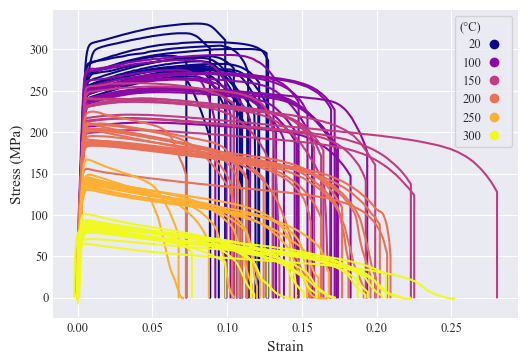

In [3]:
ds_plot(prepared_ds, **stress_strain_labels);

The vertical lines at the end of each test indicate that measurements were still taken after the specimen had separated.
We want to remove this trailing data without removing measurements from before separation.
First, we try removing the last data point from an individual curve.

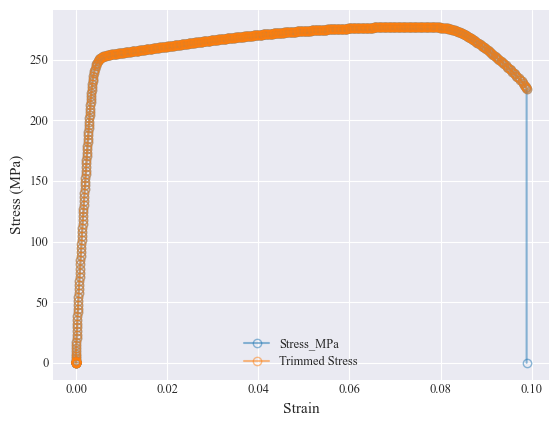

In [4]:
df = prepared_ds[0].data  # get example dataitem data
ax = df.plot(**stress_strain_labels, marker='o', mfc='none', alpha=0.5)
df[:-1].plot(x='Strain', y='Stress_MPa', label='Trimmed Stress', marker='o', mfc='none', ax=ax, alpha=0.5);

This approach worked for the single curve.
Let's check if it works for entire dataset.
To do so, we define a function that operates on a single DataItem, then apply that function to the dataset.
The function must take in and return a DataItem for it to be applied in this way.

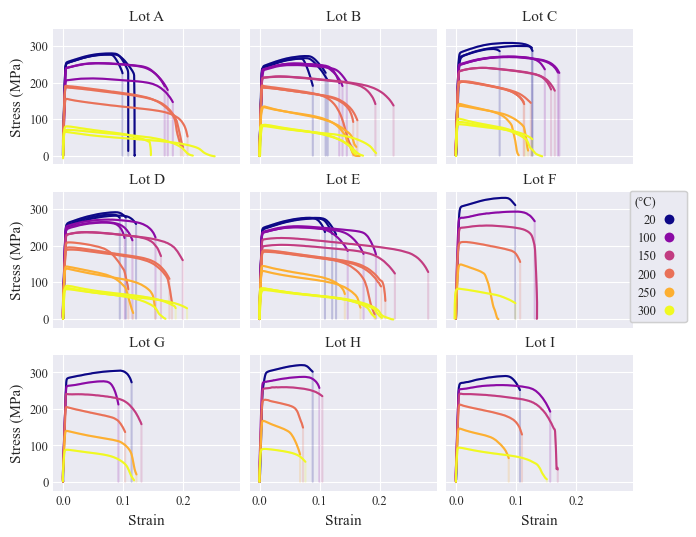

In [5]:
def trim_trailing(di: DataItem) -> DataItem:
    di.data = di.data[:-1]
    return di


trim_trailing_ds = prepared_ds.apply(trim_trailing)

axs = ds_subplots(prepared_ds, **stress_strain_labels, alpha=0.2)
ds_subplots(trim_trailing_ds, **stress_strain_labels, alpha=1, axs=axs);

It appears that removing the last data point didn't remove the trailing data for all the tests, but it did work for the majority of them.
We could try find a different approach to trim the set, or we could manually trim the remaining tests.
Manual trimming could result in a loss of traceability and repeatability of the processing procedure.
Using a screening pdf prevents this, as illustrated below.

To make a screening pdf, we define a plotting function that acts on a single DataItem and pass it to the make_screening_pdf function.
This will generate a pdf with a page for each DataItem.
Each page will display the plot as well as a checkbox and comment box.

In [6]:
def screening_plot(di: DataItem) -> None:
    test_id = di.test_id
    _ax = ds_plot(prepared_ds[{'test_id': [test_id]}],  # we can use this syntax to filter the DataSet
                  **stress_strain_labels, alpha=0.2,
                  figsize=(10, 6))  # this figsize matches the hard-coded pdf page size
    ds_plot(trim_trailing_ds[{'test_id': [test_id]}], **stress_strain_labels, ax=_ax)


# pam.processing.make_screening_pdf(trim_trailing_ds, screening_plot, 'info/02 trim trailing screening.pdf')

We then read through the screening pdf, and specify the strain at which to trim tests that still show trailing data.
Next, we read these comments to the info_table of the DataSet.

In [8]:
trim_comment_ds = pam.read_screening_pdf_fields(trim_trailing_ds, 'info/02 trim trailing screening marked.pdf')
trim_comment_ds.info_table['comment'].value_counts()

                 62
trim at 0.15     11
trim at 0.1       6
trim at 0.175     5
trim at 0.14      3
trim at 0.11      2
trim at 0.13      2
trim at 0.17      2
trim at 0.05      2
trim at 0.12      2
trim at 0.105     1
trim at 0.125     1
trim at 0.09      1
Name: comment, dtype: int64

Once the comments are in the info_table, we can access them from the info attribute of a DataItem.
The DataItem.info attribute is a pd.Series that corresponds to the row in the info_table with the DataItem's test_id.
We can then define a function that interprets and applies the comment to a DataItem, and apply this function the DataSet.

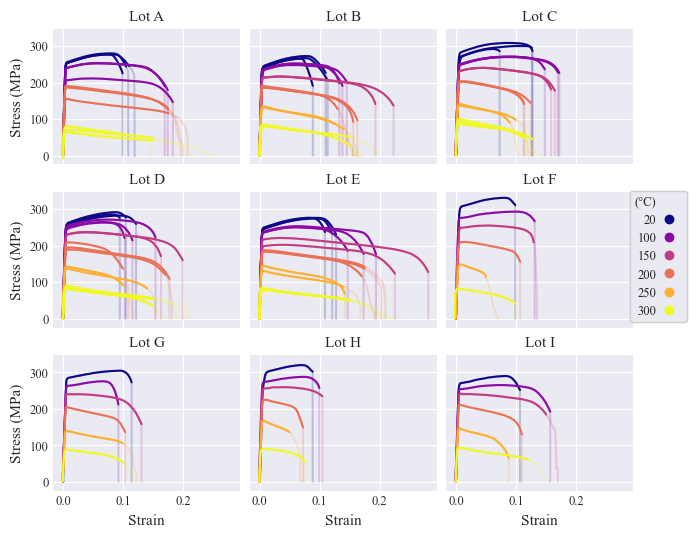

In [9]:
def screening_comment_trim(di: DataItem) -> DataItem:
    if not str(di.info['comment']).startswith('trim at'):
        return di
    trim_strain = di.info['comment'].split(' ')[2]
    di.data = di.data[di.data['Strain'] <= float(trim_strain)]
    return di


trim_comment_ds = trim_comment_ds.apply(screening_comment_trim)
axs = ds_subplots(prepared_ds, **stress_strain_labels, alpha=0.2)
ds_subplots(trim_comment_ds, **stress_strain_labels, axs=axs);

### Save trimmed data
We write the trimmed data.
By saving the data at intermediate steps, we improve traceability and repeatability.
This also improves computation speed for subsequent steps.

In [10]:
trim_comment_ds.write_output('data/02 trimmed large data', 'info/02 trimmed large info.xlsx')

### Find proportional limits and elastic modulus
It is useful to work with a set of the data trimmed to small strain, 0.01 (mm/mm).

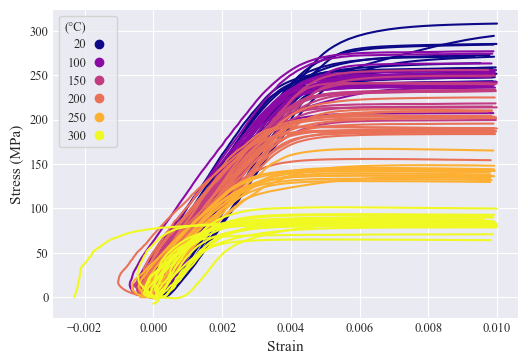

In [11]:
def trim_small(di):
    di.data = di.data[di.data['Strain'] < 0.01]
    return di


trim_small_ds = DataSet('data/02 trimmed large data', 'info/02 trimmed large info.xlsx').apply(trim_small)
ds_plot(trim_small_ds, **stress_strain_labels);

It is evident that the data needs to be shifted to the origin, i.e. foot correction needs to be applied.
To do so, we must first identify the proportional limits and elastic modulus.

In [13]:
properties_ds = trim_small_ds.apply(pam.find_upl_and_lpl,
                                    preload=36, preload_key='Stress_MPa',  # Stress at which to start searching for UPL
                                    suppress_numpy_warnings=True)
properties_ds.write_output('data/02 properties data', 'info/02 properties info.xlsx')
properties_ds = DataSet('data/02 properties data', 'info/02 properties info.xlsx')

Plot proportional limits.

KeyError: 'UPL_0'

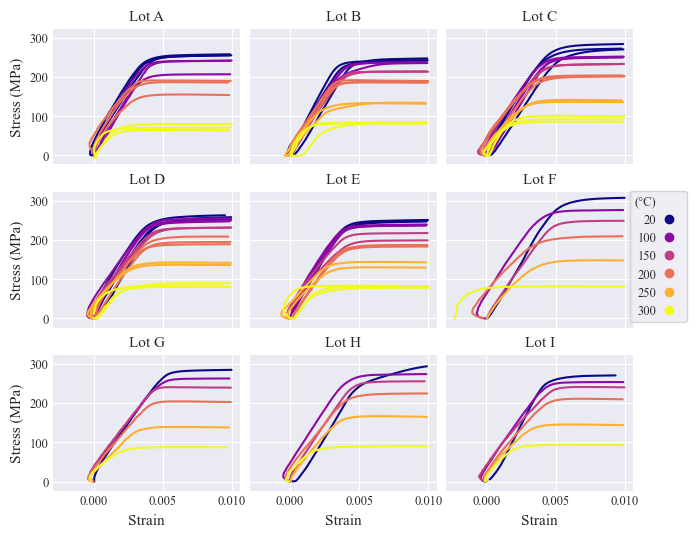

In [14]:
def plot_upl_and_lpl(di, ax):  # to use the subplot wrapper, DataItem and plt.axes arguments are required
    temp = di.info['temperature']
    UPL = (di.info['UPL_0'], di.info['UPL_1'])
    LPL = (di.info['LPL_0'], di.info['LPL_1'])
    color = styler.color_dict[temp]
    ax.axline(UPL, slope=di.info['E'], c=color, ls='--', alpha=0.4, zorder=500 + temp)
    ax.axline(UPL, slope=di.info['E'], lw=0.5, ls=':', c='k', alpha=0.1, zorder=500 + temp)
    ax.plot(*UPL, c='k', mfc=color, marker=4, markersize=6, zorder=1000 + temp)
    ax.plot(*LPL, c='k', mfc=color, marker=5, markersize=6, zorder=1000 + temp)
    return di


def pl_plot(ds):
    _ax = ds_plot(ds, **stress_strain_labels)
    list(ds.apply(plot_upl_and_lpl, ax=_ax))


def pl_plots(ds):
    _axs = ds_subplots(ds, **stress_strain_labels)
    subplot_wrapper(ds, plot_upl_and_lpl, axs=_axs)  # use the subplot wrapper


pl_plots(properties_ds);

Evidently, determining the UPL and LPL using regression worked well for some of but not all the tests.
We use a screening pdf to complete the procedure.

In [ ]:
def properties_screening_plot(di):
    test_id = di.test_id
    _ax = ds_plot(properties_ds[{'test_id': [test_id]}], **stress_strain_labels, figsize=(10,6))
    plot_upl_and_lpl(di, _ax)


# pam.processing.make_screening_pdf(properties_ds, properties_screening_plot, 'info/02 properties screening.pdf')

In [ ]:
properties_ds = pam.processing.read_screening_pdf_fields(properties_ds, 'info/02 properties screening marked.pdf')
properties_ds.info_table['comment'].value_counts()

In [ ]:
def apply_properties_screening_comments(di):
    if not str(di.info.comment).startswith('LPL'):
        return di
    lpl_stress = float(di.info.comment.split(' ')[-1])
    lpl_strain = np.interp(lpl_stress, di.data['Stress_MPa'], di.data['Strain'])
    di.info['LPL_0'] = lpl_strain
    di.info['LPL_1'] = lpl_stress
    di.info['E'] = (di.info['UPL_1'] - di.info['LPL_1'])/(di.info['UPL_0'] - di.info['LPL_0'])
    return di


screened_properties_ds = properties_ds.apply(apply_properties_screening_comments)
screened_properties_ds.write_output('data/02 screened properties data', 'info/02 screened properties info.xlsx')
pl_plots(screened_properties_ds)

### Apply foot correction

In [ ]:
def foot_correction(di):
    UPL = di.info['UPL_0'], di.info['UPL_1']
    LPL = di.info['LPL_0'], di.info['LPL_1']
    E = di.info['E']
    di.data = di.data[di.data['Stress_MPa'] >= LPL[1]]  # trim data before LPL
    strain_shift = UPL[0] - UPL[1]/E  # x-intercept of line through UPL & LPL
    di.info['foot correction'] = -strain_shift
    di.data['Strain'] = di.data['Strain'].values - strain_shift
    di.info['UPL_0'] = di.info['UPL_0'] - strain_shift
    di.info['LPL_0'] = di.info['LPL_0'] - strain_shift
    return di


foot_ds = DataSet('data/02 screened properties data', 'info/02 screened properties info.xlsx').apply(foot_correction)
pl_plot(foot_ds);

In [ ]:
foot_ds.write_output('data/02 foot corrected data', 'info/02 foot corrected info.xlsx')
foot_ds = DataSet('data/02 foot corrected data', 'info/02 foot corrected info.xlsx')

### Find proof stress

In [ ]:
proof_ds = foot_ds.apply(pam.modelling.find_proof_stress)


def plot_ps(di, ax):
    temp = di.info['temperature']
    color = styler.color_dict[temp]
    PS = di.info['YP_0.002_0'], di.info['YP_0.002_1']
    ax.plot(*PS, c='k', mfc=color, lw=0, marker='*', zorder=temp+500)
    return di


def ps_plots(ds):
    _axs = ds_subplots(ds, **stress_strain_labels)
    subplot_wrapper(ds, plot_ps, axs=_axs)


ps_plots(proof_ds)

### Apply to large strain data

In [ ]:
small_ds = proof_ds
large_ds = DataSet('data/02 trimmed large data', 'info/02 trimmed large info.xlsx')
large_ds.info_table = small_ds.info_table


def foot_correction_for_large_strain_data(di):
    di.data = di.data[di.data['Stress_MPa'] >= di.info['LPL_1']]  # trim data before LPL
    strain_shift = -di.info['foot correction']
    di.data['Strain'] = di.data['Strain'].values - strain_shift  # apply foot correction
    return di


processed_ds = large_ds.apply(foot_correction_for_large_strain_data)

### Calculate force, displacement, and ultimate tensile strength
Given engineering stress and strain.

In [ ]:
def calculate_force_disp_from_eng_curve(di: DataItem) -> DataItem:
    e = di.data['Strain'].values
    s = di.data['Stress_MPa'].values
    L_0 = di.info['h_0 (mm)']
    A_0 = di.info['A_0 (mm)']
    di.data['Displacement(mm)'] = e*L_0
    di.data['Force(kN)'] = s*A_0*0.01
    return di


processed_ds = processed_ds.apply(calculate_force_disp_from_eng_curve)

In [ ]:
ds_plot(processed_ds, x='Displacement(mm)', y='Force(kN)', ylabel='Force (kN)');

Calculate ultimate tensile strength as the stress at the maximum force.

In [ ]:
def calculate_uts(di):
    uts_index = di.data['Force(kN)'].idx_max()
    di.info['UTS_0'] = di.data['Strain'][uts_index]
    di.info['UTS_1'] = di.data['Stress_MPa'][uts_index]
    return di


processed_ds = processed_ds.apply(calculate_uts)

### Calculate true stress and strain

In [ ]:
def calculate_true_stress_strain_from_eng_curve(di: DataItem) -> DataItem:
    e = di.data['Strain'].values
    s = di.data['Stress_MPa'].values
    di.data['True Stress (MPa)'] = s*(1 + e)
    di.data['True Strain'] = np.log(1 + e)
    return di


processed_ds = processed_ds.apply(calculate_true_stress_strain_from_eng_curve)

In [ ]:
axs = ds_subplots(processed_ds, **stress_strain_labels, alpha=0.3)  # engineering stress-strain
ds_subplots(processed_ds, axs=axs, x='True Strain', y='True Stress (MPa)', xlabel='Strain', ylabel='Stress (MPa)');

### Write processed data

In [ ]:
processed_ds.write_output('data/02 processed data', 'info/02 processed info.xlsx')